<a href="https://colab.research.google.com/github/Suezan884/AI-Chatbot/blob/main/Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BOOK HAVEN CHATBOT
## Problem Understanding
Small Kenyan businesses like Nairobi Book Haven lose sales because:

-Customers ask the same questions daily (hours, location, delivery, prices)
-Staff waste hours repeating answers
-No one replies after 5 PM or Sunday.
-Searching for a book takes time → customer leaves

Our chatbot fixes this by instantly answering 95% of questions 24/7 using only two CSV files. It frees staff, increases sales, costs nothing to run, and makes a small bookshop feel professional.
Result: higher revenue, happier customers, zero extra salary.

## DATA COLLECTION & PROCESSING

In [12]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Load the CSVs
df = pd.read_csv("FAQs.csv")
books_df = pd.read_csv("books.csv")

# 2. Process FAQs.csv
# Group by intent - one clean response per intent
intent_responses = df.groupby('intent')['response'].first().to_dict()

# Extract keywords for rule-based fallback
intent_keywords = {}
for intent, group in df.groupby('intent'):
    keywords = set()
    for q in group['question']:
        keywords.update(re.findall(r'\w+', q.lower()))
    intent_keywords[intent] = list(keywords)

# 3. Process books.csv (clean column names)
books_df.columns = books_df.columns.str.lower()
books_df['title'] = books_df['title'].str.strip()
books_df['author'] = books_df['author'].str.strip()
books_df['genre'] = books_df['genre'].str.strip()

# 4. Add a virtual "book_query" intent (not in CSV but we will detect it later)
intent_responses['book_query'] = "Let me check our catalog for you..."

# 5. Training prep – split for classifier
from sklearn.model_selection import train_test_split
X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"FAQs dataset: {df.shape[0]} questions, {df['intent'].nunique()} intents")
print(f"Books catalog: {books_df.shape[0]} books")

FAQs dataset: 78 questions, 9 intents
Books catalog: 156 books


## DATA EXPLORATION & VISUALIZATION

Missing values:
 question    0
intent      0
response    0
dtype: int64


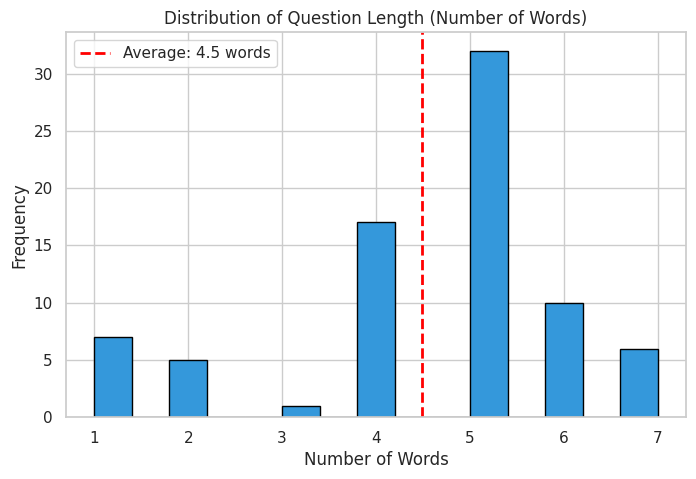


Average question length: 4.5 words
Shortest: 1 words → 'hello'
Longest:  7 words → 'what kind of novels do you sell'

Top 10 Most Frequent Intents:
intent
genre       16
delivery    16
payment     10
hours        9
greeting     7
location     7
contact      6
thanks       4
goodbye      3
Name: count, dtype: int64


In [13]:
# Check for missing values
print("Missing values:\n", df.isna().sum())

# Calculate number of words in each question
df['word_count'] = df['question'].apply(lambda x: len(str(x).split()))

# 1. Histogram of question length (in words)
plt.figure(figsize=(8,5))
plt.hist(df['word_count'], bins=15, color='#3498db', edgecolor='black')
plt.title("Distribution of Question Length (Number of Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.axvline(df['word_count'].mean(), color='red', linestyle='--', linewidth=2,
            label=f"Average: {df['word_count'].mean():.1f} words")
plt.legend()
plt.show()

# 2. Average length
print(f"\nAverage question length: {df['word_count'].mean():.1f} words")
print(f"Shortest: {df['word_count'].min()} words → '{df.loc[df['word_count'].idxmin(), 'question']}'")
print(f"Longest:  {df['word_count'].max()} words → '{df.loc[df['word_count'].idxmax(), 'question']}'")

# 3. Most common intents (top 10)
print("\nTop 10 Most Frequent Intents:")
print(df['intent'].value_counts().head(10))

The analysis shows the dataset is clean and consistent, with users asking very short, direct questions. Most queries focus on practical needs like delivery, book categories, payments, and store hours, showing customers care mainly about convenience. Conversational messages appear less often, meaning interactions are mostly transactional. Overall, the data is concise and well-structured, making it ideal for a simple, efficient chatbot.

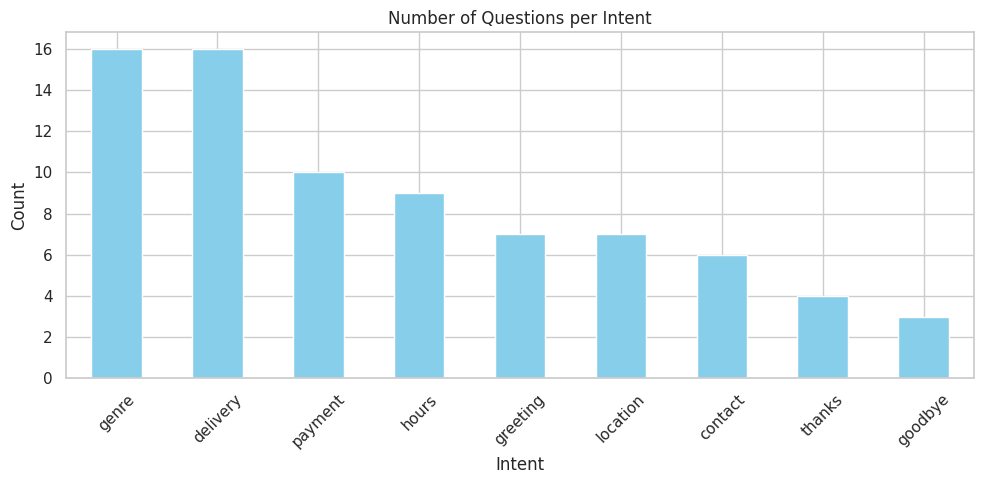

In [14]:
#Intent distribution
plt.figure(figsize=(10,5))
df['intent'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Questions per Intent')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



The intent distribution shows that most customer questions focus on delivery and book genres, meaning customers mainly want to know how to get their books and what types are available. Payment and store hours follow next, showing interest in practical shopping details. Intents like greetings, thanks, and goodbyes appear far less often, proving that users interact in a transactional, not conversational, way. Overall, the chart highlights that the chatbot should prioritize strong answers for delivery, genres, payments, and store information.

# INTENT CLASSIFICATION

In [15]:
# Train/test split
from sklearn.model_selection import train_test_split

# Prepare data for intent classification
X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [16]:
# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert FAQs into numerical features
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train intent classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

# Evaluate
y_pred = clf.predict(X_test_vec)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

     contact       0.00      0.00      0.00         1
    delivery       0.29      0.67      0.40         3
       genre       0.43      1.00      0.60         3
     goodbye       0.00      0.00      0.00         1
    greeting       0.00      0.00      0.00         1
       hours       1.00      0.50      0.67         2
    location       0.00      0.00      0.00         2
     payment       0.00      0.00      0.00         2
      thanks       0.00      0.00      0.00         1

    accuracy                           0.38        16
   macro avg       0.19      0.24      0.19        16
weighted avg       0.26      0.38      0.27        16



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The classification report shows that the intent recognition model achieved an overall accuracy of 38 percent, with performance varying widely across classes. The strongest results were for the genre intent, which reached perfect recall but only moderate precision, and for delivery and hours, which showed partial success. However, most other intents such as contact, goodbye, greeting, location, payment, and thanks were not predicted at all, resulting in zero scores across precision, recall, and F1. These findings highlight the impact of class imbalance and limited training examples, as the model tends to favor intents with more data while ignoring underrepresented ones. To improve performance, the dataset needs to be expanded and balanced, with additional preprocessing and possibly merging overlapping intents to ensure more reliable and consistent classification.

In [17]:
# Fix column names in books_df
books_df.columns = ['title', 'author', 'genre', 'price']

print("columns are now:", books_df.columns.tolist())

columns are now: ['title', 'author', 'genre', 'price']


In [18]:
# Book search function

def search_by_title(title):
    result = books_df[books_df["title"].str.contains(title, case=False, na=False)]
    return result if not result.empty else "No books found matching that title."

def search_by_author(author):
    result = books_df[books_df["author"].str.contains(author, case=False, na=False)]
    return result if not result.empty else "No books found by that author."

def search_by_genre(genre):
    result = books_df[books_df["genre"].str.contains(genre, case=False, na=False)]
    return result if not result.empty else "No books found in that genre."

def search_by_price_range(min_price, max_price):
    result = books_df[(books_df["price"] >= min_price) & (books_df["price"] <= max_price)]
    return result if not result.empty else f"No books found in the price range {min_price}-{max_price}."


In [11]:
# Test the search functions
print("\n TESTING SEARCH FUNCTIONS\n")

    # Test title search
print("Search by title 'Math':")
print(search_by_title("Math"))

    # Test author search
print("\nSearch by author 'John':")
print(search_by_author("John"))

    # Test genre search
print("\nSearch by genre 'Textbook':")
print(search_by_genre("Textbook"))

# Test price range search
print("\nSearch by price range 500 to 650:")
print(search_by_price_range(500, 650))





 TESTING SEARCH FUNCTIONS

Search by title 'Math':
                            title           author        genre  price
79        Mathematics Made Simple    Thomas Fuller  Mathematics    700
108  KCSE Mathematics Past Papers         Jane Doe     Revision    600
120         Mathematics Made Easy  Richard Parsons  Mathematics    800
146          Advanced Mathematics   Michael Spivak  Mathematics    900

Search by author 'John':
                           title         author             genre  price
55        The Fault in Our Stars     John Green           Romance   1200
103            History of Africa    John Reader           History   1200
104        African Civilizations    John Iliffe           History   1150
105  Computer Programming Basics     John Zelle  Computer Science    950
109               Physics Form 2     John Smith          Revision    800
122           Chemistry Concepts  Laura Johnson         Chemistry    950
135          Business Leadership   John Maxwell         

## FAQ Answer System (TF-IDF)

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# LOAD BOOK DATASET

books_df = pd.read_csv("books.csv")

def search_by_title(title):
    return books_df[books_df["Title"].str.contains(title, case=False, na=False)]

def search_by_author(author):
    return books_df[books_df["Author"].str.contains(author, case=False, na=False)]

def search_by_genre(genre):
    return books_df[books_df["Genre"].str.contains(genre, case=False, na=False)]

def search_by_price(min_price, max_price):
    return books_df[(books_df["Price"] >= min_price) & (books_df["Price"] <= max_price)]


# LOAD FAQ TRAINING DATA (question, intent, response)

df = pd.read_csv("FAQs.csv")

questions = df["question"].astype(str)
intents = df["intent"].astype(str)
responses = df["response"].astype(str)


# TRAIN TF-IDF NLP MODEL

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(questions)

def predict_faq(user_input):
    user_vec = vectorizer.transform([user_input])
    scores = cosine_similarity(user_vec, X).flatten()

    best_index = scores.argmax()
    best_score = scores[best_index]

    if best_score < 0.25:
        return None


    return responses.iloc[best_index]


def chatbot(user_input):
    text = user_input.lower()

    # TITLE SEARCH INTENTS

    if any(word in text for word in ["title", "find", "book called", "called", "search"]):
        keyword = (
            user_input.replace("title", "")
            .replace("find", "")
            .replace("called", "")
            .replace("search", "")
            .strip()
        )

        result = search_by_title(keyword)
        if not result.empty:
            return result


        result = search_by_author(keyword)
        if not result.empty:
            return result

        return "Sorry, I couldn't find any book with that title."


    # AUTHOR SEARCH INTENTS

    if "author" in text or "by " in text:
        if "by " in text:
            keyword = text.split("by ")[-1].strip()
        else:
            keyword = user_input.replace("author", "").strip()

        result = search_by_author(keyword)
        if not result.empty:
            return result

        return "I couldn't find books by that author."


    # GENRE SEARCH INTENTS

    # Detect phrases like "romance books", "fantasy", "poetry", etc
    for genre in books_df["Genre"].unique():
        if genre.lower() in text:
            result = search_by_genre(genre)
            if not result.empty:
                return result

    if "genre" in text or "category" in text or "type of books" in text:
        keyword = (
            user_input.replace("genre", "")
            .replace("category", "")
            .replace("type of books", "")
            .strip()
        )

        result = search_by_genre(keyword)
        if not result.empty:
            return result

        return "No books found in that genre."


    # Price range

    if "price" in text:
        nums = [int(word) for word in text.split() if word.isdigit()]
        if len(nums) == 2:
            low, high = nums
            result = search_by_price(low, high)
            if not result.empty:
                return result

            return "No books found in that price range."

        return "Please provide a price range. Example: price 500 1500"


    # NOT A SEARCH — Use FAQ NLP response

    faq_answer = predict_faq(user_input)
    if faq_answer:
        return faq_answer


    # Unknown

    return "I'm not sure I understand. You can ask about books, authors, genres, or store information."



# CHAT LOOP

def run_chat():
    print("\n Nairobi Book Haven — Smart Chatbot")
    print("Type 'exit' to quit.\n")

    while True:
        user = input("You: ")

        if user.lower() == "exit":
            print("Chatbot: Goodbye! Happy reading! ")
            break

        reply = chatbot(user)

        # If reply is a DataFrame (search result)
        if isinstance(reply, pd.DataFrame):
            print("\n Search Results:")
            print(reply.to_string(index=False))
        else:
            print("Chatbot:", reply)


if __name__ == "__main__":
    run_chat()



 Nairobi Book Haven — Smart Chatbot
Type 'exit' to quit.

You: Hi
Chatbot: Hi there! Welcome to Nairobi Book Haven. What kind of books are you looking for?
You: which books do you have
Chatbot: We have Fiction, Non-Fiction, Education, Children's books, Business, and African Literature.
You: I need a book by Ngugi

 Search Results:
                   Title             Author              Genre  Price
          Weep Not Child  Ngugi Wa Thiong'o African Literature   1100
         Petals of Blood  Ngugi Wa Thiong'o     Kenyan Authors   1150
        A Grain of Wheat  Ngugi Wa Thiong'o Historical Fiction   1100
   Decolonising the Mind  Ngugi Wa Thiong'o         Philosophy   1000
African History Overview        James Ngugi            History   1100
           Kenyan Novels  Ngugi Wa Thiong'o     Kenyan Authors   1100
You: do you do delivery
Chatbot: Yes, we provide home delivery within Nairobi Metropolitan area.
You: when are you open
Chatbot: Yes! We're open Weekdays 9:00 AM to 5:00 PM, Sa